In [5]:
import numpy as np
import matplotlib.pyplot as plt
import nestle
import corner
from scipy.interpolate import interp1d
from scipy.integrate import quad_vec
from tqdm import tqdm
import pandas as pd
import os
import sys
sys.path.append('./Utils')
CurrentPath = os.getcwd()
sndata = pd.read_csv(CurrentPath + '/Data/parsonage.txt', sep = ' ', engine='python')

In [ ]:
BAO_z = np.array([0.094,0.157,0.402,0.402,0.526,0.526,0.597,0.597])
BAO_val = np.array([0.08,1849.05,4006.83,43.48,4650.20,51.31,5053.80,58.64])
BAO_err = np.array([0.003,66.648,59.924,1.334,68.103,1.512,75.657,1.292])
BAO_ind = np.array([1,2,3,4,3,4,3,4]) 
# 1 : r_s/D_V, 2 : D_V(r_d,fid/r_d), 3 : D_M(r_d,fid/r_d), 4 : H(r_d/r_d,fid)
BAO_data = pd.DataFrame({
    'z': BAO_z,
    'val': BAO_val,
    'err': BAO_err,
    'ind': BAO_ind
})
BAO_data.to_csv('./Data/BAO_data.csv', index=False)
BAO_data = pd.read_csv('./Data/BAO_data.csv')

# 1. Flat LCDM SN only

In [8]:
def E_inverse_flat(z, Omega_m): # return 1/E(z) = H0/H(z)
    Omega_L = 1 - Omega_m
    E2 = Omega_m*(1+z)**3 + Omega_L
    if (E2<0).any():
        E2=np.nan
    E = np.sqrt(E2)
    return 1/E


def Other_stuff_flat(z, parm): # parm[0] = Omegam, parm[1] = Omegalamb
    """
    Other_stuff_flat(z, parm) = integral from 0 to z of 1/E(z) dz
    Other_stuff_flat(z, parm) = H0/c*D_M(z)"""
    Omegam = parm[0]
    grid = np.linspace(z.min(), z.max(), 100)
    grid_dist = np.array([quad_vec(E_inverse_flat, 0,n, args=(Omegam))[0] for n in grid])
    interp_func = interp1d(grid, grid_dist, kind='linear', fill_value='extrapolate')
    integral = interp_func(z)
    return integral
def B(func, parm,z):
    """
    B(Omegam, Omegalamb) = 5*log10((1+z)*proper distance*H0/c)
    m(z) = A + B(Omegam, Omegalamb)
    input : 
        func : proper distance*H0/c (Other_stuff_flat or Other_stuff_curved)
        parm : [Omegam, Omegalamb] 
        z : redshift
    output :
        Bval : B(Omegam, Omegalamb)
    """
    Bval = 5*np.log10((1+z)*func(z, parm))
    return Bval

def A(func,mb, dmb,z, parm):
#   func : Other_stuff_flat or Other_stuff_curved 
    inv_dmb = np.sum(1/dmb**2)
    A = 1/inv_dmb*np.sum((mb - B(func,parm,z))/(dmb**2))
    return A

def Loglike_SN_flat(parm):
    mb = sndata['mb'].values
    dmb = sndata['dmb'].values
    z = sndata['zcmb'].values
    m_z = A(Other_stuff_flat, mb,dmb, z, parm) + B(Other_stuff_flat, parm, z) # m_z = A + B(Omegam, Omegalamb)
    diff = (mb - m_z)**2
    chisq = np.sum(diff/dmb**2)
    return -chisq/2

def prior_SN_flat(x):
    # return Omegam in [0,1] for flat universe
    # x is a uniform distribution in [0,1]
    return x

it=   884 logz=-1657.571802niter: 885
ncall: 1327
nsamples: 985
logz: -1657.155 +/-  0.263
h:  6.932 
logzerr: 0.2632801732754446
Best-fit parameters: Omegam = 0.999 +/- 0.001


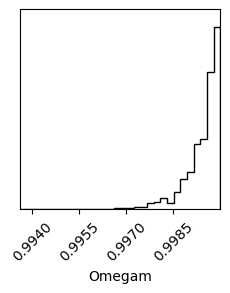

In [11]:
result_SN_flat = nestle.sample(Loglike_SN_flat, prior_SN_flat, ndim=1,npoints=100, method='single', callback=nestle.print_progress)
print(result_SN_flat.summary(), f"\nlogzerr: {result_SN_flat.logzerr}")
p_SN_flat, cov_SN_flat = nestle.mean_and_cov(result_SN_flat.samples, result_SN_flat.weights)
print(f"Best-fit parameters: Omegam = {p_SN_flat[0]:.3f} +/- {np.sqrt(cov_SN_flat[0,0]):.3f}")

fig = corner.corner(result_SN_flat.samples,weights=result_SN_flat.weights, labels=['Omegam'],
                    range=[0.99999], bins=30)

In [ ]:
import pickle
with open('data.pkl','wb') as f:
    pickle.dump(result_SN_flat, f)

Type:        Result
String form:
niter: 885
           ncall: 1327
           logz: -1657.1546478243974
           logzerr: 0.2632801732754446
           h: <...> 2,
           -1649.56484968, -1649.55139623, -1649.19938837, -1649.59218454,
           -1649.24384491])
Length:      9
File:        /opt/anaconda3/lib/python3.12/site-packages/nestle.py
Docstring:  
Represents a sampling result.

Since this class is essentially a subclass of dict with attribute
accessors, one can see which attributes are available using the
`keys()` method.